# US Video Game Sales in Relation to ESRB Rating and Genre

By Riley Stange
<br>For Thinkful Capstone 1: Business Research

## 1. Introduction

Having been an avid video gamer for most of my life, I found this to be an interesting subject matter, in which I have relevant experience.

I found a dataset on Kaggle, Video Game Sales with Ratings, and after looking through it, I realized it would be interesting to see what insights can be gathered from how an ESRB maturity rating correlates with sales figures. 

Starting with a more broad comparison between different ratings, and then breaking down the differences between various genres, the goal is to see the degree of impact a maturity rating has on the sale of video games, in general, and in more specific cases tied to the different genres.

### ESRB Ratings

**E**: "Everyone": Content is generally suitable for all ages. May contain minimal cartoon, fantasy or mild violence and/or infrequent use of mild language.

**E10+**: "Everyone 10+": Content is generally suitable for ages 10 and up. May contain more cartoon, fantasy or mild violence, mild language and/or minimal suggestive themes.

**T**: "Teen": Content is generally suitable for ages 13 and up. May contain violence, suggestive themes, crude humor, minimal blood, simulated gambling and/or infrequent use of strong language.

**M**: "Mature 17+": Content is generally suitable for ages 17 and up. May contain intense violence, blood and gore, sexual content and/or strong language.

**AO**: "Adults Only 18+": Content suitable for adults ages 18 and up. May include prolonged scenes of intense violence, graphic sexual content and/or gambling with real currency.

### Relevance

From investors, publishing companies, all the way down to individual game studios; the insights gained from this experiment will help them to understand the profitability of content in video games, in general, and most importantly, in the context of different genres. This helps to maximize the use of investment capital and labor towards designing video games in such a way that they are most relevant to their target audience, and most profitable.


## 2. Hypothesis

**Ho**: There is no significant difference in sales based on maturity rating.

**Ha**: There is a significant difference in sales based on maturity rating.

## 3. Data

In [14]:
# Initialize the environment
import math
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

%matplotlib inline
sns.set(style="darkgrid")

In [3]:
sales = pd.read_csv(
    "~/projects/video-game-sales-by-maturity-rating/Video_Games_Sales_as_at_22_Dec_2016.csv"
)

In [17]:
# Only pull from entries where there are US sales
# and where there is a rating
na_sales = sales[
    (sales["NA_Sales"] > 0) & sales.Rating.notnull()
]
na_sales["NA_Sales"].count()

9174

### Source
The data is sourced from [Kaggle](https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings) and contains 9,174 observations, after filtering for our criteria of video games that have sold > 0 copies in the US, and have a rating. Changed anything with the obsolete (as of 1998) rating of 'K-A' to 'E', since they are considered equivalent.

In [18]:
na_sales["Rating"].value_counts()

E       3764
T       2650
M       1423
E10+    1328
EC         8
AO         1
Name: Rating, dtype: int64

There are 3,764 observations rated 'E', 2,650 rated 'T', 1,423 rated 'M', 8 rated 'EC', and 1 rated 'AO'. It appears that additional filtering of the dataset is in order, as we only have one observation in the 'AO' category, and only 8 in the now (as of 2018) retired 'EC' category.

In [21]:
# Eliminating the sparse/irrelevant Adults Only/Early Childhood rated observations.
na_sales_e_to_m = sales[
    (sales["NA_Sales"] > 0)
    & sales.Rating.notnull()
    & (sales["Rating"] != "AO")
    & (sales["Rating"] != "EC")
]

## 4. Methods

First, I will graph the data in general to get an idea of it's distribution.

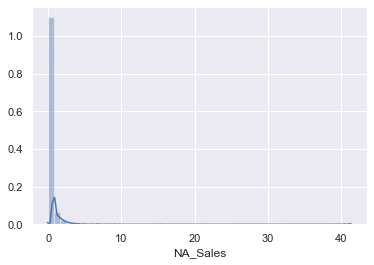

In [70]:
sns.distplot(na_sales_e_to_m["NA_Sales"])
plt.show()

Definitely not normal, no need to do any statistical tests to confirm. I will now use the Kruskal-Wallace test to see if I can refuse the null.

In [72]:
stats.kruskal(
    na_sales_e_to_m["NA_Sales"][
        na_sales_e_to_m["Rating"] == "E"
    ],
    na_sales_e_to_m["NA_Sales"][
        na_sales_e_to_m["Rating"] == "E10+"
    ],
    na_sales_e_to_m["NA_Sales"][
        na_sales_e_to_m["Rating"] == "T"
    ],
    na_sales_e_to_m["NA_Sales"][
        na_sales_e_to_m["Rating"] == "M"
    ],
)

KruskalResult(statistic=63.500405432609654, pvalue=1.0497237548692599e-13)

From this, we can tell that at least one group is significantly different from the other three, and so for this broader null, we can reject it and move onto a more focused hypothesis and get more details on how significant those differences are, and based on what Ratings and Genres.

As we can see above, we have a good sample size, but amounts that are disproportionate to one another. Lets try grouping the four groups into two groups:

**Group A**: For Ages Under 13: Observations from games rated 'E' and 'E10+'.

**Group B**: For Ages 13 and up: Observations from games rated 'T' and 'M'.

In [52]:
e_e10 = na_sales_e_to_m[
    na_sales_e_to_m["Rating"].isin(["E", "E10+"])
]
t_m = na_sales_e_to_m[
    na_sales_e_to_m["Rating"].isin(["T", "M"])
]
print(
    "E-E10+: "
    + str(e_e10["NA_Sales"].count())
    + " observations."
)
print(
    "T-M: "
    + str(t_m["NA_Sales"].count())
    + " observations."
)

E-E10+: 5092 observations.
T-M: 4073 observations.


Now that we have two groups of a similar observation size, let's plot them to get an idea if they are normally distributed or not. Then we will have the stats.describe() method give us the skewness and kurtosis to confirm what we are seeing.

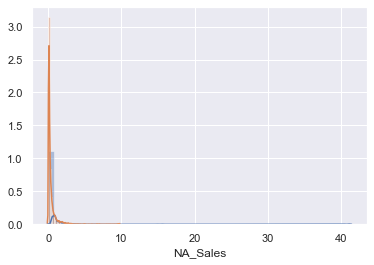

DescribeResult(nobs=5092, minmax=(0.01, 41.36), mean=0.3238688138256088, variance=0.852539576579775, skewness=22.72208193877407, kurtosis=837.8519324303887)
DescribeResult(nobs=4073, minmax=(0.01, 9.7), mean=0.3702995335133808, variance=0.557886157801845, skewness=6.0052919235897715, kurtosis=50.552341390083384)


In [65]:
sns.distplot(e_e10["NA_Sales"])
sns.distplot(t_m["NA_Sales"])
plt.show()

print(stats.describe(e_e10["NA_Sales"]))
print(stats.describe(t_m["NA_Sales"]))

There is no question here, both groups are far from being normal, so we will utilize non-parametric testing methods to test our hypothesis.

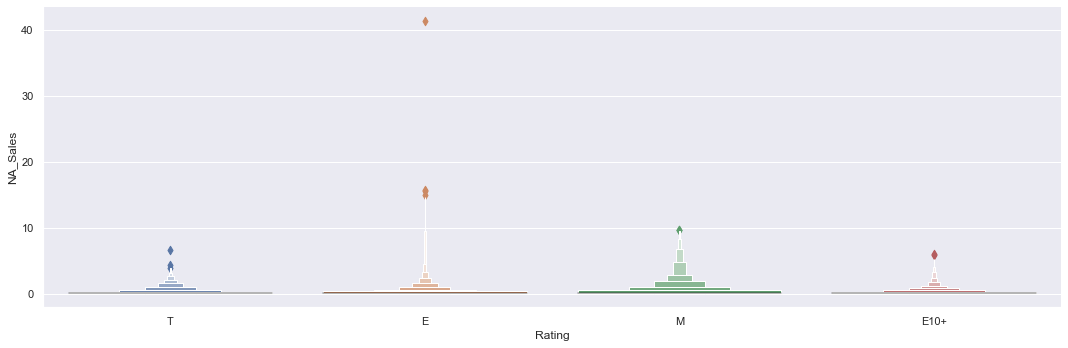

In [22]:
sns.catplot(
    x="Rating",
    y="NA_Sales",
    kind="boxen",
    aspect=3,
    data=na_sales_e_to_m.sort_values("NA_Sales")
)
plt.show()

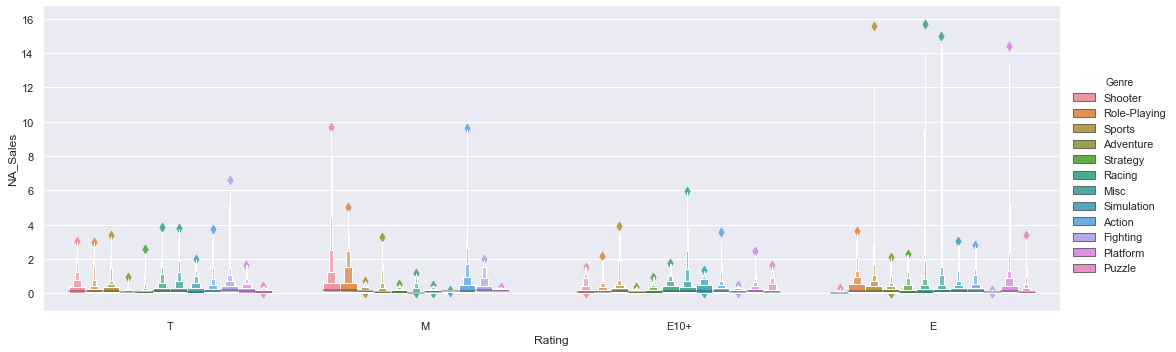

In [115]:
sns.catplot(
    x="Rating",
    y="NA_Sales",
    kind="boxen",
    hue="Genre",
    aspect=3,
    data=na_sales_e_to_m.sort_values("NA_Sales")
)
plt.show()

That's better! Though this could still be a clearer picture:<br>
By making each Genre it's own plot, with Rating as a color-coded category to show clear trends and differences among all the genres.

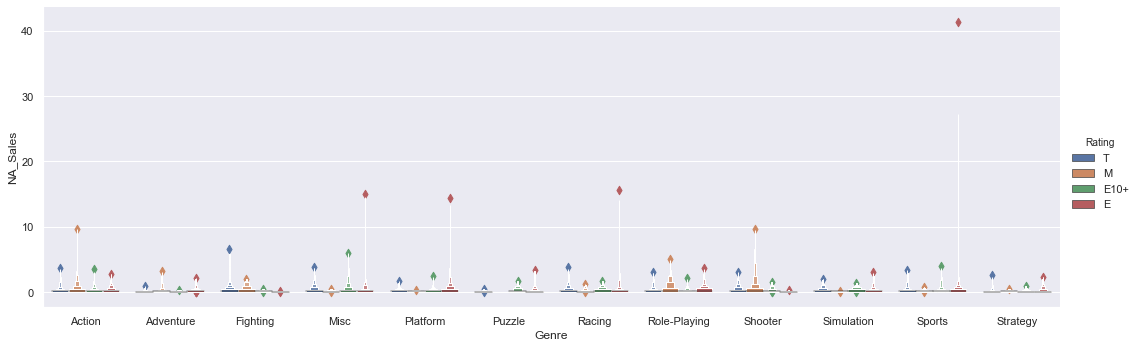

In [24]:
sns.catplot(
    x="Genre",
    y="NA_Sales",
    kind="boxen",
    hue="Rating",
    aspect=3,
    data=na_sales_e_to_m.sort_values("Genre")
)
plt.show()

Starting from the top of the chart: we have four titles that sold between 14-16 million USD, one from Sports, one from Racing, one from Misc, and one from Platform. All of which are rated E.<br>
This aligns with intuition, to see that the best sellers (including the one outlier that sold for 41 million USD) are all rated E, where their content is not offensive to anyone in particular, allowing for the largest potential audience.<br>
This however, does not mean that games of other ratings do not have a valid audience, and as we see, there are only four (5 if you include the outlier) of games that sold for more than 14 million USD, but if you look at where the bulk of the action is happening, below the 4 million, and mostly below the 3 million mark, it seems that there is a potentially much larger market for M rated games, especially within the Shooter and Role-Playing genres.<br>
A next step is to take a closer look at each genre and compare the sales statistics based on genre.

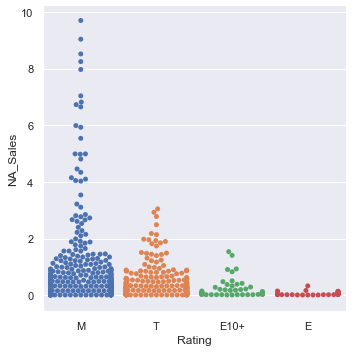

In [137]:
sns.catplot(
    x="Rating",
    y="NA_Sales",
    kind="swarm",
    data=na_sales_e_to_m[
        na_sales_e_to_m["Genre"] == "Shooter"
    ],
)
plt.show()

Since we are working with a smaller set of data, we can utilize a swarm plot to see each individual data point, which makes it clearer where the density lies in this genre. 

In [140]:
tukey = pairwise_tukeyhsd(
    endog=na_sales_e_to_m["NA_Sales"],  # Data
    groups=na_sales_e_to_m["Rating"],  # Groups
    alpha=0.05, # Significance level
)  

In [141]:
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
E,E10+,-0.0673,0.02,-0.1271,-0.0075,True
E,M,0.1926,0.001,0.1343,0.2509,True
E,T,-0.0467,0.0564,-0.0942,0.0008,False
E10+,M,0.2599,0.001,0.1884,0.3314,True
E10+,T,0.0206,0.8125,-0.0423,0.0836,False
M,T,-0.2393,0.001,-0.3009,-0.1777,True


Lets check the two-tail confidence interval between Mature and Teen rated shooters first

In [2]:
def get_95_ci(array_1, array_2):
    sample_1_n = array_1.shape[0]
    sample_2_n = array_2.shape[0]
    sample_1_mean = array_1.mean()
    sample_2_mean = array_2.mean()
    sample_1_var = array_1.var()
    sample_2_var = array_2.var()
    mean_difference = sample_2_mean - sample_1_mean
    std_err_difference = math.sqrt(
        (sample_1_var / sample_1_n)
        + (sample_2_var / sample_2_n)
    )
    margin_of_error = 1.96 * std_err_difference
    ci_lower = mean_difference - margin_of_error
    ci_upper = mean_difference + margin_of_error
    return (
        "The difference in means at the 95% confidence interval (two-tail) is between "
        + str(ci_lower)
        + " and "
        + str(ci_upper)
        + "."
    )

In [150]:
m_shooters = na_sales_e_to_m[
    (na_sales_e_to_m["Rating"] == "M")
    & (na_sales_e_to_m["Genre"] == "Shooter")
]
t_shooters = na_sales_e_to_m[
    (na_sales_e_to_m["Rating"] == "T")
    & (na_sales_e_to_m["Genre"] == "Shooter")
]

print(
    get_95_ci(
        t_shooters["NA_Sales"], m_shooters["NA_Sales"]
    )
)

print(
    "The average sale for a Mature rated shooter is "
    + str(m_shooters["NA_Sales"].mean())
    + ", or over 661K USD"
)

The difference in means at the 95% confidence interval (two-tail) is between 0.19712538915966707 and 0.4484317230099417.
The average sale for a Mature rated shooter is 0.6611821705426357, or over 661K USD


We can see that, with a 95% confidence interval (two-tail), that Mature shooters sell between nearly 200K and 450K USD more than Teen rated shooters, with the mean M-Rated shooter total sales coming in at over 661K USD.